Author: Harry Yau

Date: August 30, 2019

In [1]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt

import re
import seaborn as sns
import datetime
from datetime import timedelta
import geopandas

In [2]:
data_folder = 'data'
pickle_folder = 'pickle'
shp_folder = 'shp_files'

#load station data
station_info_df = pd.read_csv(data_folder + '/' + 'station_data.csv', dtype={'id': str, 'name': str, 'lat': float, 'lon': float, 'total_slots':int})

def load_pickle(url):
    '''
    Function to load pickle file
    '''
    infile = open(url, 'rb')
    data = pickle.load(infile)
    infile.close()
    return data

filename = 'mobi_cleaned.pkl'
combined_df = load_pickle(pickle_folder + '/' + filename)

filename = 'YVR_wxdata.pkl'
weather_df = load_pickle(pickle_folder + '/' + filename)

In [3]:
#Converts lat lon to the correct projection corrdinates.

from pyproj import Proj, transform

inProj = Proj(init='epsg:4326')
outProj = Proj(init='epsg:26910')

lon=[]
lat=[]
for i in range(0, len(station_info_df)):
    out = transform(inProj,outProj, station_info_df['lon'][i], station_info_df['lat'][i])
    lon.append(out[0])
    lat.append(out[1])
    
    
station_info_df['lat_conv'] = lat
station_info_df['lon_conv'] = lon

del lat, lon

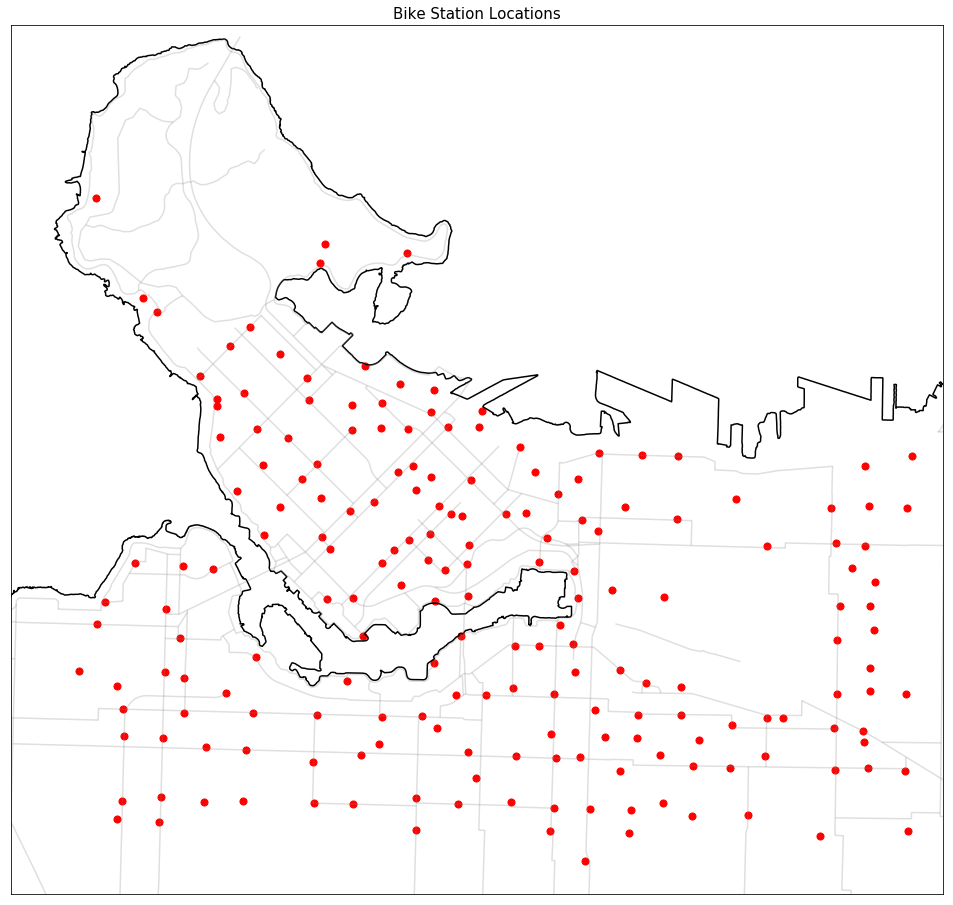

In [4]:
vancouver_shp = geopandas.read_file(data_folder +'/'+ shp_folder + '/' + 'shoreline2002.shp')
vancouver_bike_shp = geopandas.read_file(data_folder +'/'+ shp_folder + '/' + 'bikeways.shp')

fig, ax = plt.subplots(figsize = (20,16)) 
vancouver_shp.plot(ax=ax, color='k')
vancouver_bike_shp.plot(ax = ax, color='grey', alpha=0.25)

plt.scatter(x='lon_conv', y='lat_conv', data=station_info_df, c='r', s=50, alpha=None)
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
plt.xlim(488000, 495500)
plt.ylim(5455500, 5462500)
plt.title('Bike Station Locations', size=15)
plt.show();

### Trips between stations - Lines

In [5]:
def assemble_pairs(stations_df, station_info_df):
    
    '''
    Assembles the DataFrame for all bike station combinations 
    '''

    x = pd.crosstab(stations_df['Departure station'], stations_df['Return station'])
    x = x.reindex(index=station_info_df['id'], columns=station_info_df['id'], fill_value=0)

    matrix_count = x.copy()
    matrix_count['Departure Station']=matrix_count.index
    matrix_count_melt = pd.melt(matrix_count, id_vars='Departure Station', value_vars=station_info_df['id'])
    matrix_count_melt['dep_ret'] = matrix_count_melt['Departure Station'] + '-' + matrix_count_melt['id']
    matrix_count_melt.columns = ['Departure station', 'Return station', 'value', 'dep_ret'] 



    import itertools
    iters = itertools.combinations(station_info_df['id'], 2)

    #unzip all the combinations
    stn_left, stn_right = zip(*list(iters))

    unique_stn_pairs = pd.DataFrame({'stn_left':stn_left, 'stn_right':stn_right})
    unique_stn_pairs['dep_ret_one'] = unique_stn_pairs['stn_left'] + '-' + unique_stn_pairs['stn_right']
    unique_stn_pairs['dep_ret_two'] = unique_stn_pairs['stn_right'] + '-' + unique_stn_pairs['stn_left']

    unique_stn_pairs = unique_stn_pairs.merge(matrix_count_melt[['value', 'dep_ret']], 
                                              how='left', left_on='dep_ret_one', right_on='dep_ret',
                                              suffixes=('_one', '_two'))
    unique_stn_pairs.drop(columns='dep_ret', inplace=True)
    unique_stn_pairs= unique_stn_pairs.merge(matrix_count_melt[['value', 'dep_ret']], 
                                             how='left', left_on='dep_ret_two', right_on='dep_ret',
                                             suffixes=('_one', '_two'))
    unique_stn_pairs.drop(columns='dep_ret', inplace=True)

    # does not include the same.. stations. (RETURN TRIPS EXCLUDED)
    unique_stn_pairs['total'] = unique_stn_pairs[['value_one', 'value_two']].sum(axis=1)

    unique_stn_pairs = unique_stn_pairs.merge(station_info_df[['id', 'lat_conv', 'lon_conv']], 
                                              how='left', left_on='stn_left', right_on='id',
                                              suffixes=('_left', '_right'))
    unique_stn_pairs = unique_stn_pairs.merge(station_info_df[['id', 'lat_conv', 'lon_conv']], 
                                              how='left', left_on='stn_right', right_on='id',
                                              suffixes=('_left', '_right'))


    unique_stn_pairs.sort_values(by = 'total', ascending=False)
    unique_stn_pairs['total_pct'] = (unique_stn_pairs['total']/(unique_stn_pairs['total'].max()))*.8

    temp_df_one = unique_stn_pairs[['lon_conv_right', 'lat_conv_right']]  - np.array(unique_stn_pairs[['lon_conv_left', 'lat_conv_left']])
    temp_df_two = unique_stn_pairs[['lon_conv_left', 'lat_conv_left']]  - np.array(unique_stn_pairs[['lon_conv_right', 'lat_conv_right']])


    temp_df_one.columns = ['dx_one', 'dy_one']
    temp_df_two.columns = ['dx_two', 'dy_two']

    unique_stn_pairs = unique_stn_pairs.join([temp_df_one, temp_df_two], sort=False)
    unique_stn_pairs = unique_stn_pairs[unique_stn_pairs['total'] > 0].reset_index(drop=True)
    
    return (unique_stn_pairs)

In [6]:
stations_df = combined_df[['Departure station', 'Return station']]
unique_stn_pairs = assemble_pairs(stations_df, station_info_df)

In [7]:
def custom_plot_lines(unique_stn_pairs, station_info_df, title=None):
    
    vancouver_shp = geopandas.read_file(data_folder +'/'+ shp_folder + '/' + 'shoreline2002.shp')
    vancouver_bike_shp = geopandas.read_file(data_folder +'/'+ shp_folder + '/' + 'bikeways.shp')
    
    fig, ax = plt.subplots(figsize = (20,16)) 
    vancouver_shp.plot(ax=ax, color='k')
    vancouver_bike_shp.plot(ax = ax, color='grey', alpha=0.25)
    plt.scatter(x='lon_conv', y='lat_conv', data=station_info_df, c='r', s=50, alpha=None)

    for i in unique_stn_pairs.index:
        plt.plot(unique_stn_pairs.loc[i, ['lon_conv_left', 'lon_conv_right']], \
                 unique_stn_pairs.loc[i, ['lat_conv_left', 'lat_conv_right']], \
                 'b-', linewidth=(unique_stn_pairs.loc[i,'total_pct']*5), alpha=0.8)

    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    plt.xlim(488000, 495500)
    plt.ylim(5455500, 5462500)
    plt.title(title, size=15);

It appears that there are certain routes that are have a higher count

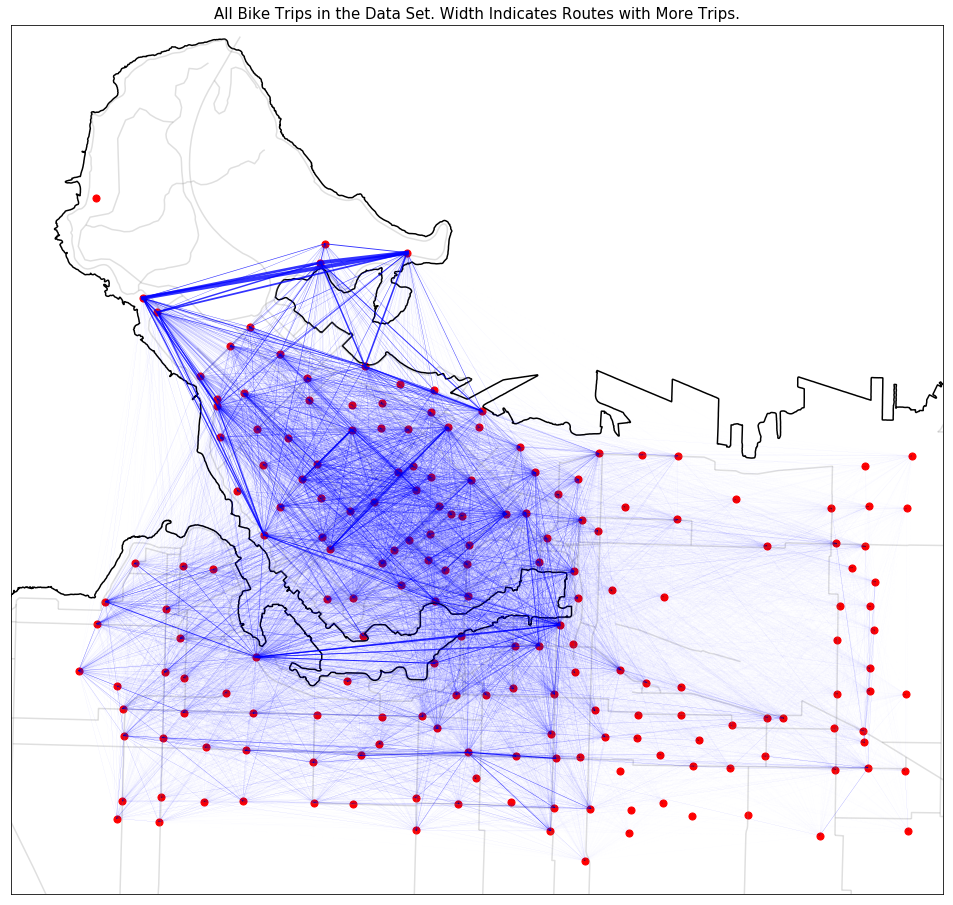

In [8]:
stations_df = combined_df[['Departure station', 'Return station']]
unique_stn_pairs = assemble_pairs(stations_df, station_info_df)
custom_plot_lines(unique_stn_pairs, station_info_df, title='All Bike Trips in the Data Set. Width Indicates Routes with More Trips.')

### Trips between stations - With directional arrows

In [9]:
def custom_plot_directional(unique_stn_pairs, station_info_df, target_pair, title=None):
    
    vancouver_shp = geopandas.read_file(data_folder +'/'+ shp_folder + '/' + 'shoreline2002.shp')
    vancouver_bike_shp = geopandas.read_file(data_folder +'/'+ shp_folder + '/' + 'bikeways.shp')
    
    fig, ax = plt.subplots(figsize = (20,16)) 
    vancouver_shp.plot(ax=ax, color='k')
    vancouver_bike_shp.plot(ax = ax, color='grey', alpha=0.25)
    plt.scatter(x='lon_conv', y='lat_conv', data=station_info_df, c='r', s=50, alpha=None)

    for i in target_pair.index:
        a1 = unique_stn_pairs.loc[i,'total_pct']*(unique_stn_pairs.loc[i, 'value_one']/unique_stn_pairs.loc[i, 'total'])
        a2 = unique_stn_pairs.loc[i,'total_pct']*(unique_stn_pairs.loc[i, 'value_two']/unique_stn_pairs.loc[i, 'total'])

        if(unique_stn_pairs.loc[i, 'value_one'] > unique_stn_pairs.loc[i, 'value_two']):
            a1 += 0.3
        else:
            a2 += 0.3

        #STN LEFT TO STN RIGHT
        plt.arrow(unique_stn_pairs.loc[i, ['lon_conv_left']][0], unique_stn_pairs.loc[i, ['lat_conv_left']][0], 
                  unique_stn_pairs.loc[i, ['dx_one']][0], unique_stn_pairs.loc[i, ['dy_one']][0], 
                  length_includes_head=True, 
                  head_width=100, head_length=200, width=unique_stn_pairs.loc[i,'total_pct']*5, 
                  fc="b",  ec='b',  shape='left', alpha=a1)

        #STN RIGHT TO STN LEFT
        plt.arrow(unique_stn_pairs.loc[i, ['lon_conv_right']][0], unique_stn_pairs.loc[i, ['lat_conv_right']][0], 
                  unique_stn_pairs.loc[i, ['dx_two']][0], unique_stn_pairs.loc[i, ['dy_two']][0], 
                  length_includes_head=True, 
                  head_width=100, head_length=200, width=unique_stn_pairs.loc[i,'total_pct']*5, 
                  fc="b", ec='b', shape='left', alpha=a2)    

    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    plt.xlim(488000, 495500)
    plt.ylim(5455500, 5462500)
    plt.title(title, size=15);

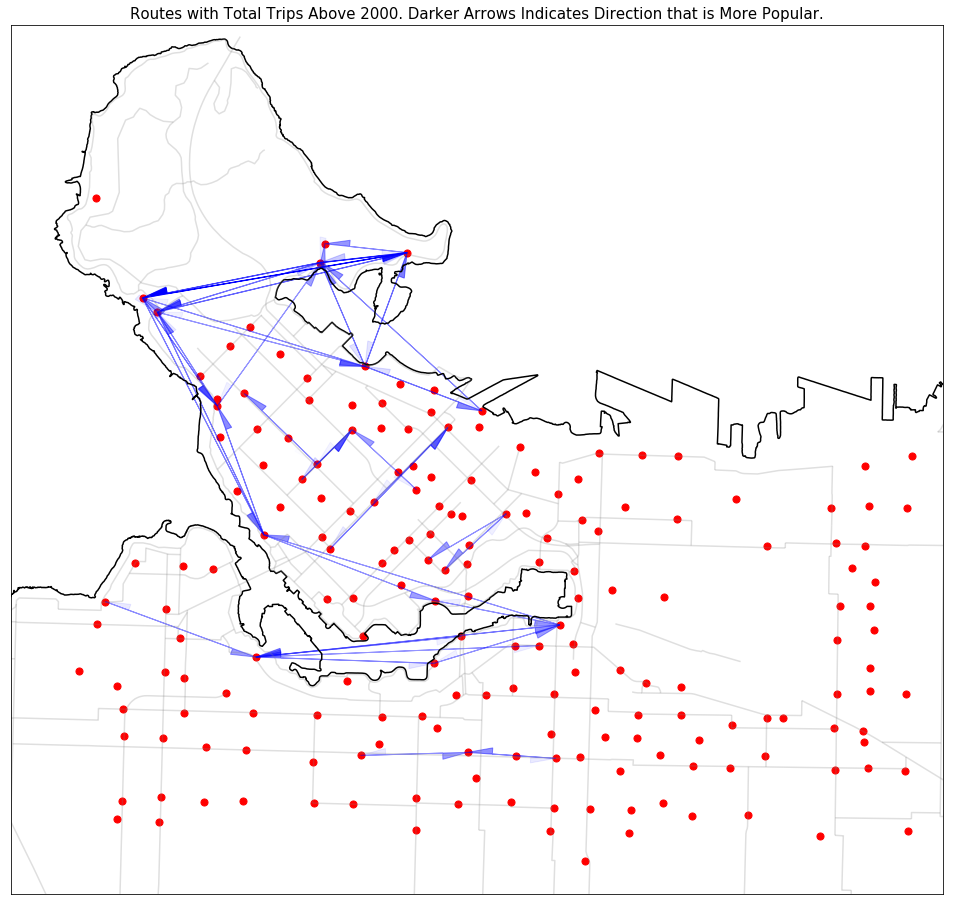

In [11]:
stations_df = combined_df[['Departure station', 'Return station']]
unique_stn_pairs = assemble_pairs(stations_df, station_info_df)

threshold_val = 2000

target_pair = unique_stn_pairs.sort_values(by='total', ascending=False)
target_pair = target_pair[(target_pair['total'] >= threshold_val)]

custom_plot_directional(unique_stn_pairs, station_info_df, target_pair, 
                        title=('Routes with Total Trips Above ' + str(threshold_val) +'. Darker Arrows Indicates Direction that is More Popular.'))

### Manual Regions for Station Locations

After analyzing the directional arrows in the previous section, I decided to label the stations into areas. The rationale for this is to try and capture bike movement information between different regions. For example, there are certain routes where there are disproportionate amount of bike trips due to the area being a tourist location.

In [12]:
stanley_park_index = ['0103', '0105','0101','0209','0102','0104', ]
main_knight_index = ['0199', '0213', '0221', '0227', '0229', 
                    '0233', '0234',  '0236', '0237', '0238',  '0246', '0248', 
                    '0255', '0256', '0257', '0258', '0260', '0261',
                    '0262', '0265', '0266',  '0281',
                    '0282',   '0287', '0297', '0298', '0179']
knight_comm_index = ['0280', '0285', '0225', '0224', '0272', '0222', '0223', '0232', 
                    '0231', '0253', '0235', '0239', '0252', '0240', '0250', '0241',
                    '0273', '0249', '0254', '0242', '0245', '0244', '0274', '0283', '0278']
southern_fc_seawall_west_index = ['0204', '0154', '0155', '0147', '0077', '0066']
southern_fc_seawall_east_index=[ '0143', '0010', '0009', '0173', '0174', '0006', '0011', '0177' ]
eastern_fc_seawall_index = ['0193', '0148', '0218', '0054']
northern_fc_seawall_west_index = ['0083', '0084', '0060', '0028', '0031', '0047', '0028', '0031']
northern_fc_seawall_east_index = ['0057', '0017', '0136', '0137', ]
coal_harbor_seawall_index=['0035', '0034', '0201', '0014']
dt_westend_index = ['0092', '0093', '0032', '0033', '0041', '0040', '0096', '0048', '0087', '0088', '0187', '0050', '0036', '0207', '0123', '0126', '0190', ]
dt_core_index = ['0016', '0002', '0024', '0021', '0099', '0019', '0063', '0015','0129', '0012', '0125', '0025']
dt_southern_corridor_index = ['0037', '0039', '0089', '0196', '0082', '0079', '0058', '0138']
dt_yaletown_index = ['0004', '0078', '0027', '0064', '0026', '0044']
dt_gastown_chinatown_index = ['0052', '0030', '0167', '0150', '0098', '0005', '0053', '0055', '0161', '0230',]
granville_west_index = ['0113', '0115', '0152', '0114', '0203', '0071',
                        '0070', '0205', '0068',  '0208', '0109', '0140', '0069',
                        '0153', '0139', '0076', '0110', '0159', '0108', '0065']
granville_east_index = ['0211', '0202', '0166', '0112', '0080', '0191', '0192', '0081', '0008',
                        '0106', '0130', '0001', '0007', '0072', '0172', '0180', '0171', '0165', 
                        '0073', '0119', '0107', '0176', '0132', '0133', '0134', '0074', '0206',
                        '0198', '0197']

In [13]:
#Check if we accounted for all the stations
index_list = [stanley_park_index,
                southern_fc_seawall_west_index,
                southern_fc_seawall_east_index,
                eastern_fc_seawall_index,
                northern_fc_seawall_west_index,
                northern_fc_seawall_east_index,
                coal_harbor_seawall_index,
                dt_westend_index,
                dt_core_index,
                dt_southern_corridor_index,
                dt_yaletown_index,
                dt_gastown_chinatown_index,
                granville_west_index,
                granville_east_index,
                main_knight_index,
                knight_comm_index,]


ind = sum(index_list, [])

station_info_df['id'].isin(ind).sum() == station_info_df.shape[0]

region_label_df = pd.DataFrame({'id': range(0,len(index_list)), 'Name':
    ['Stanley Park', 'Seawall - Southern False Creek West',  'Seawall - Southern False Creek East',
    'Seawall - Eastern False Creek', 'Seawall - Northern False Creek West', 'Seawall - Northern False Creek East',
     'Seawall - Coal Harbour',
    'Downtown - West End', 'Downtown - Core', 'Downtown - Southern Corridor', 'Downtown - Yaletown',
    'Gastown - Chinatown - Railtown', 'Kitsilano', 'Mount Pleasant', 'Main - Knight', 'Knight - Commercial' ]
    })


In [14]:
station_info_df['Region Name'] = ''
station_info_df['Region'] = ''

for i, val in enumerate(index_list):
    station_info_df.loc[station_info_df['id'].isin(val), 'Region'] = i
    station_info_df.loc[station_info_df['id'].isin(val), 'Region Name'] = region_label_df.loc[i, 'Name']    

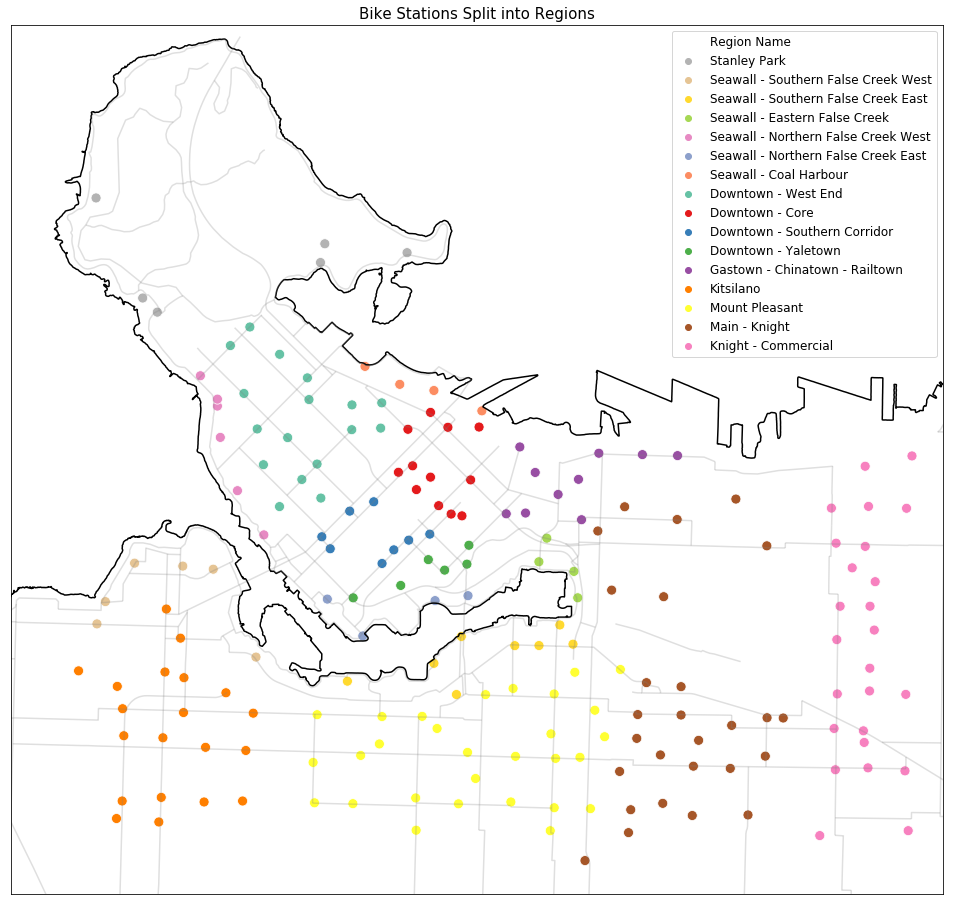

In [15]:
fig, ax = plt.subplots(figsize = (20,16)) 
vancouver_shp = geopandas.read_file(data_folder +'/'+ shp_folder + '/' + 'shoreline2002.shp')
vancouver_bike_shp = geopandas.read_file(data_folder +'/'+ shp_folder + '/' + 'bikeways.shp')
vancouver_shp.plot(ax=ax, color='k')
vancouver_bike_shp.plot(ax = ax, color='grey', alpha=0.25)

sns.scatterplot(x='lon_conv', y='lat_conv', hue='Region Name', hue_order=region_label_df.Name,data=station_info_df, 
                    s=100, alpha=1.0,
                    palette = (sns.color_palette("Set2_r", 8,) + sns.color_palette("Set1", 8)),  
                    ax=plt.gca())
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Bike Stations Split into Regions', size=15)
ax.legend(fontsize=12);
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
plt.xlim(488000, 495500)
plt.ylim(5455500, 5462500);

In [16]:
group_1 = ['24 Hour',
           'Archived Day',  
           'Archived Single Trip Pass',]

group_2 = ['90 Day',
          'Archived Monthly Plus',
          'Archived Monthly Standard', 
          'Archived Monthly Basic',]

group_3 = ['365 Day Founding Plus', 
          '365 Standard',
          '365 Day Founding Standard', 
          '365 Plus', 
          '365 Corporate Plus', 
          '365 Corporate Plus Renewal', 
          '365 Corporate Standard Renewal',
          '365 Day Pass Plus SALE',
          '365 Corporate Standard', 
          '365 Day Pass Standard SALE',
          'Vancity Community Pass',
          'Archived Founding Standard', 
          'Archived Founding Plus',
          'VIP', ]

In [17]:
temp_df = combined_df.copy()

temp_df.index = combined_df['Departure']

temp_df['Membership Group'] = temp_df['Membership Type']
temp_df.loc[temp_df['Membership Group'].isin(group_1), 'Membership Group'] = 'Daily'
temp_df.loc[temp_df['Membership Group'].isin(group_2), 'Membership Group'] = 'Monthly'
temp_df.loc[temp_df['Membership Group'].isin(group_3), 'Membership Group'] = '365_Type'

t = temp_df[['Membership Group']].groupby('Membership Group').resample('D').count()
t.columns = ['Value']

t = t.reset_index()

new_t = t.pivot(index='Departure', columns='Membership Group', values='Value')

In [18]:
new_t.head()

Membership Group,365_Type,Daily,Monthly
Departure,,,
2017-01-01,82.0,28.0,38.0
2017-01-02,111.0,69.0,60.0
2017-01-03,204.0,2.0,98.0
2017-01-04,222.0,29.0,119.0
2017-01-05,272.0,19.0,126.0


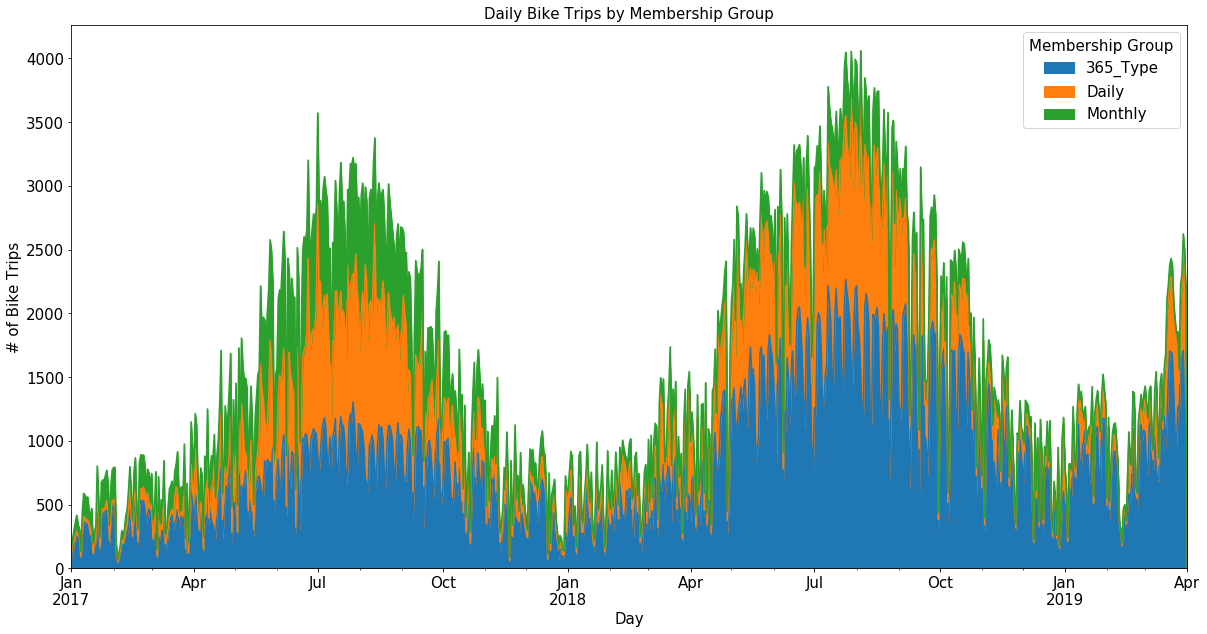

In [19]:
ax = new_t.plot.area(figsize=(20,10))
ax.tick_params(labelsize=15)
ax.set_xlabel('Day', fontsize=15)
ax.set_ylabel('# of Bike Trips', fontsize=15)
ax.set_title('Daily Bike Trips by Membership Group', fontsize=15)
ax.legend(title='Membership Group', title_fontsize=15, fontsize=15);

In [20]:
new_t_sum = new_t.sum(axis=1)
new_t_perc = new_t.apply( lambda x: (x/new_t_sum)*100, axis=0)

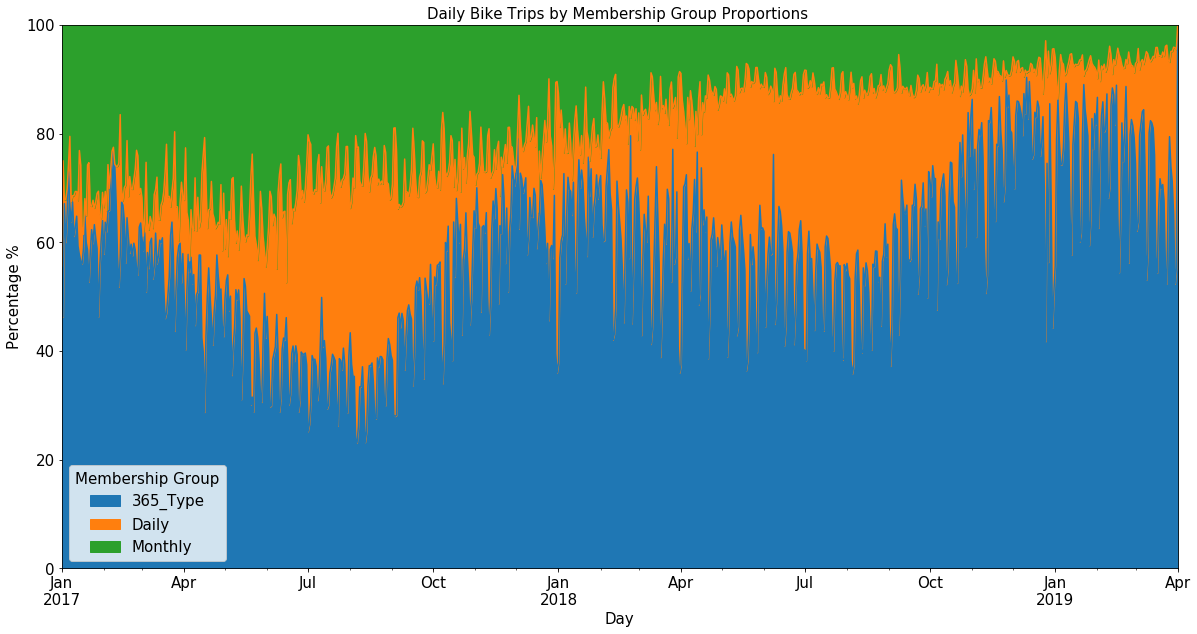

In [21]:
ax = new_t_perc.plot.area(figsize=(20,10))
ax.tick_params(labelsize=15)
ax.set_xlabel('Day', fontsize=15)
ax.set_ylabel('Percentage %', fontsize=15)
ax.set_title('Daily Bike Trips by Membership Group Proportions ', fontsize=15)
ax.set_ylim(0,100)
ax.legend(title='Membership Group', title_fontsize=15, fontsize=15);